In [1]:
import sys
import requests
import zipfile
import urllib3
import matplotlib
import re
import numpy as np

from pathlib import Path
from os import getcwd, makedirs, rename
from os.path import join, basename, isdir

sys.path.append(str(Path(getcwd()).parent))
current_dir = getcwd()
print(current_dir)

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

urllib3.disable_warnings()

/home/jvas22/Documentos/joao/AnaliseEnsinoSuperiorPublico/notebooks


In [2]:
class Dados:
    def __init__(self):
        dicionarioDados = pd.read_csv(join(Path(getcwd()).parent,'dicionario_dados.csv'), sep = ";")
        self.schema = dicionarioDados
        self.municipios = pd.read_csv(join(Path(getcwd()).parent,'dados','Municipios-Brasileiros'), sep = ",")

        self.parser = dict([[column, eval(parser.replace("“","\"").replace("”","\""))] for column, parser in dicionarioDados.loc[(dicionarioDados['TRADUCAO'].notna()),['COLUNA','TRADUCAO']].values])
        self.fillna = dict(dicionarioDados.loc[dicionarioDados['NULO'].notna(),['COLUNA','NULO']].values)
        self.dtypes = dict(dicionarioDados[['COLUNA','TIPOS']].values)
        self.meaning = dict(dicionarioDados[['COLUNA', 'DESCRICAO']])

    #METODO PARA TRADUZIR OS IDS SEGUNDO O DICIONARIO DE DADOS
    def traduzDados(self):
        print("Iniciando merge das variaveis com o dicionário de dados")
        for col in self.schema.loc[self.schema['NULO'].notna(),'COLUNA'].values:
            self.DataFrame[col] = self.DataFrame[col].fillna(self.fillna[col]).astype(self.dtypes[col])

        for col in self.schema.loc[self.schema['TRADUCAO'].notna(),'COLUNA'].values:
            self.DataFrame.replace(self.parser,inplace=True)

    #METODO PARA BAIXAR BASE DE DADOS CASO NÃO ENCONTRAR A PASTA "DADOS"
    def baixaDados(self, url, endereco=None):
        if not isdir(join(Path(getcwd()).parent,"dados")):
            makedirs(join(Path(getcwd()).parent,"dados"))
        if endereco is None:
            endereco = join(Path(getcwd()).parent,"dados", basename(url.split("/")[4]))
        resposta = requests.get(url, stream=True, verify=False)
        if resposta.status_code == requests.codes.OK:
            with open(endereco, 'wb') as novo_arquivo:
                    for parte in resposta.iter_content(chunk_size=256):
                        novo_arquivo.write(parte)
            print("Download finalizado. Arquivo salvo em: {}".format(endereco))
            if ('zip' in endereco) and not isdir(join(Path(getcwd()).parent,"dados",str(basename(url.split("/")[4])).replace(".zip",""))):
                with zipfile.ZipFile(join(Path(getcwd()).parent,"dados", basename(url.split("/")[4])), 'r') as zip_ref:
                    zip_ref.extractall(join(Path(getcwd()).parent,"dados"))
                rename(join(Path(getcwd()).parent,"dados","Microdados do Censo da Educaç╞o Superior 2020"),join(Path(getcwd()).parent,"dados",str(basename(url.split("/")[4])).replace(".zip","")))
        else:
            resposta.raise_for_status()

    def importaDados(self, entrada="MICRODADOS_CADASTRO_CURSOS_2020.CSV"):
        print("Iniciando leitura do arquivo {}".format(entrada))
        self.baixaDados("https://download.inep.gov.br/microdados/microdados_censo_da_educacao_superior_2020.zip")
        self.baixaDados("https://raw.githubusercontent.com/kelvins/Municipios-Brasileiros/main/csv/municipios.csv")
        caminho_entrada = join(Path(getcwd()).parent,"dados","microdados_censo_da_educacao_superior_2020", "dados")
        self.DataFrame = pd.read_csv(join(caminho_entrada,str(entrada).split(",")[0]), sep = ';', low_memory = False, encoding = 'latin-1').reset_index()
        count = 0
        for arquivo in str(entrada).replace(" ","").split(","):
            if count == 0:
                count = count+1
            else:
                self.DataFrame.merge(pd.read_csv(join(caminho_entrada,arquivo), sep = ';', low_memory = False, encoding = 'latin-1').reset_index(), how = 'left', on = 'index')
        self.DataFrame = self.DataFrame.set_index('index')

class Individuo:
    def __init__(self, nome):
        self.nome = nome
        self.cor = None
        self.sexo = None
        self.faixa_etaria = None
        self.dicIntervaloModal = None
        self.tabelaMedidasResumo = None

    def alteraNomeColunas(self):
        dicIndividuo = {'ingressantes':'QT_ING_', 'concluintes':'QT_CONC_','matriculados':'QT_MAT_'}
        self.cor.columns = [re.sub(dicIndividuo[self.nome],'',coluna) for coluna in self.cor.columns.values]
        self.sexo.columns = [re.sub(dicIndividuo[self.nome],'',coluna) for coluna in self.sexo.columns.values]
        self.faixa_etaria.columns = [tuple(re.sub(dicIndividuo[self.nome],'',coluna).split('_')) for coluna in self.faixa_etaria.columns.values]

    def IntervaloModal(self, variavelAgrupamento):
        self.tabelaMedidasResumo = self.faixa_etaria.groupby(variavelAgrupamento).sum().transpose()
        self.dicIntervaloModal = {coluna:self.tabelaMedidasResumo.reset_index().loc[self.tabelaMedidasResumo.reset_index()[coluna] == self.tabelaMedidasResumo.reset_index()[coluna].max(), 'index'].index[0] for coluna in self.tabelaMedidasResumo.columns.values}

    def Moda(self, variavelAgrupamento):
        self.IntervaloModal('CO_MUNICIPIO')
        variacao_anterior = self.tabelaMedidasResumo.iloc[[self.dicIntervaloModal[variavelAgrupamento]]][variavelAgrupamento].values[0] - self.tabelaMedidasResumo.iloc[[self.dicIntervaloModal[variavelAgrupamento]-1]][variavelAgrupamento].values[0]
        variacao_posterior = self.tabelaMedidasResumo.iloc[[self.dicIntervaloModal[variavelAgrupamento]]][variavelAgrupamento].values[0] - self.tabelaMedidasResumo.iloc[[self.dicIntervaloModal[variavelAgrupamento]+1]][variavelAgrupamento].values[0]
        limite_inferior = int(self.tabelaMedidasResumo.iloc[[self.dicIntervaloModal[variavelAgrupamento]]][variavelAgrupamento].index[0][0])
        amplitude = int(self.tabelaMedidasResumo.iloc[[self.dicIntervaloModal[variavelAgrupamento]]][variavelAgrupamento].index[0][1])+1 - limite_inferior
        denominador = variacao_anterior+variacao_posterior
        return limite_inferior+((variacao_anterior*amplitude)/denominador) if (variacao_anterior+variacao_posterior > 0) else 0
    


In [3]:
dados = Dados()
dados.importaDados("MICRODADOS_CADASTRO_CURSOS_2020.CSV")
dados.traduzDados()
#dados.DataFrame

Iniciando leitura do arquivo MICRODADOS_CADASTRO_CURSOS_2020.CSV
Download finalizado. Arquivo salvo em: /home/jvas22/Documentos/joao/AnaliseEnsinoSuperiorPublico/dados/microdados_censo_da_educacao_superior_2020.zip
Download finalizado. Arquivo salvo em: /home/jvas22/Documentos/joao/AnaliseEnsinoSuperiorPublico/dados/Municipios-Brasileiros
Iniciando merge das variaveis com o dicionário de dados


In [4]:
UniversidadePublica = dados.DataFrame.loc[(dados.DataFrame.TP_ORGANIZACAO_ACADEMICA == 'Universidade') & (dados.DataFrame.TP_REDE == 'Pública')]
print('Cursos de universidades públicas: {}/{}'.format(UniversidadePublica.shape[0], dados.DataFrame.shape[0]))

Cursos de universidades públicas: 13220/335629


In [5]:
ingressantes = Individuo('ingressantes')
ingressantes.cor = UniversidadePublica.groupby(['NO_REGIAO', 'NO_UF', 'CO_MUNICIPIO'])[dados.schema.loc[(dados.schema.INDIVIDUO == 'ingressantes') & (dados.schema.INDICADORES == 'cor'), 'COLUNA']].sum()
ingressantes.sexo= UniversidadePublica.groupby(['NO_REGIAO', 'NO_UF', 'CO_MUNICIPIO'])[dados.schema.loc[(dados.schema.INDIVIDUO == 'ingressantes') & (dados.schema.INDICADORES == 'sexo'), 'COLUNA']].sum()
ingressantes.faixa_etaria = UniversidadePublica.groupby(['NO_REGIAO', 'NO_UF', 'CO_MUNICIPIO'])[dados.schema.loc[(dados.schema.INDIVIDUO == 'ingressantes') & (dados.schema.INDICADORES == 'faixa_etaria'), 'COLUNA']].sum()
ingressantes.alteraNomeColunas()

concluintes = Individuo('concluintes')
concluintes.cor = UniversidadePublica.groupby(['NO_REGIAO', 'NO_UF', 'CO_MUNICIPIO'])[dados.schema.loc[(dados.schema.INDIVIDUO == 'concluintes') & (dados.schema.INDICADORES == 'cor'), 'COLUNA']].sum()
concluintes.sexo= UniversidadePublica.groupby(['NO_REGIAO', 'NO_UF', 'CO_MUNICIPIO'])[dados.schema.loc[(dados.schema.INDIVIDUO == 'concluintes') & (dados.schema.INDICADORES == 'sexo'), 'COLUNA']].sum()
concluintes.faixa_etaria = UniversidadePublica.groupby(['NO_REGIAO', 'NO_UF', 'CO_MUNICIPIO'])[dados.schema.loc[(dados.schema.INDIVIDUO == 'concluintes') & (dados.schema.INDICADORES == 'faixa_etaria'), 'COLUNA']].sum()
concluintes.alteraNomeColunas()

array([<AxesSubplot: title={'center': 'Centro-Oeste'}>,
       <AxesSubplot: title={'center': 'Nordeste'}>,
       <AxesSubplot: title={'center': 'Norte'}>,
       <AxesSubplot: title={'center': 'Sudeste'}>,
       <AxesSubplot: title={'center': 'Sul'}>], dtype=object)

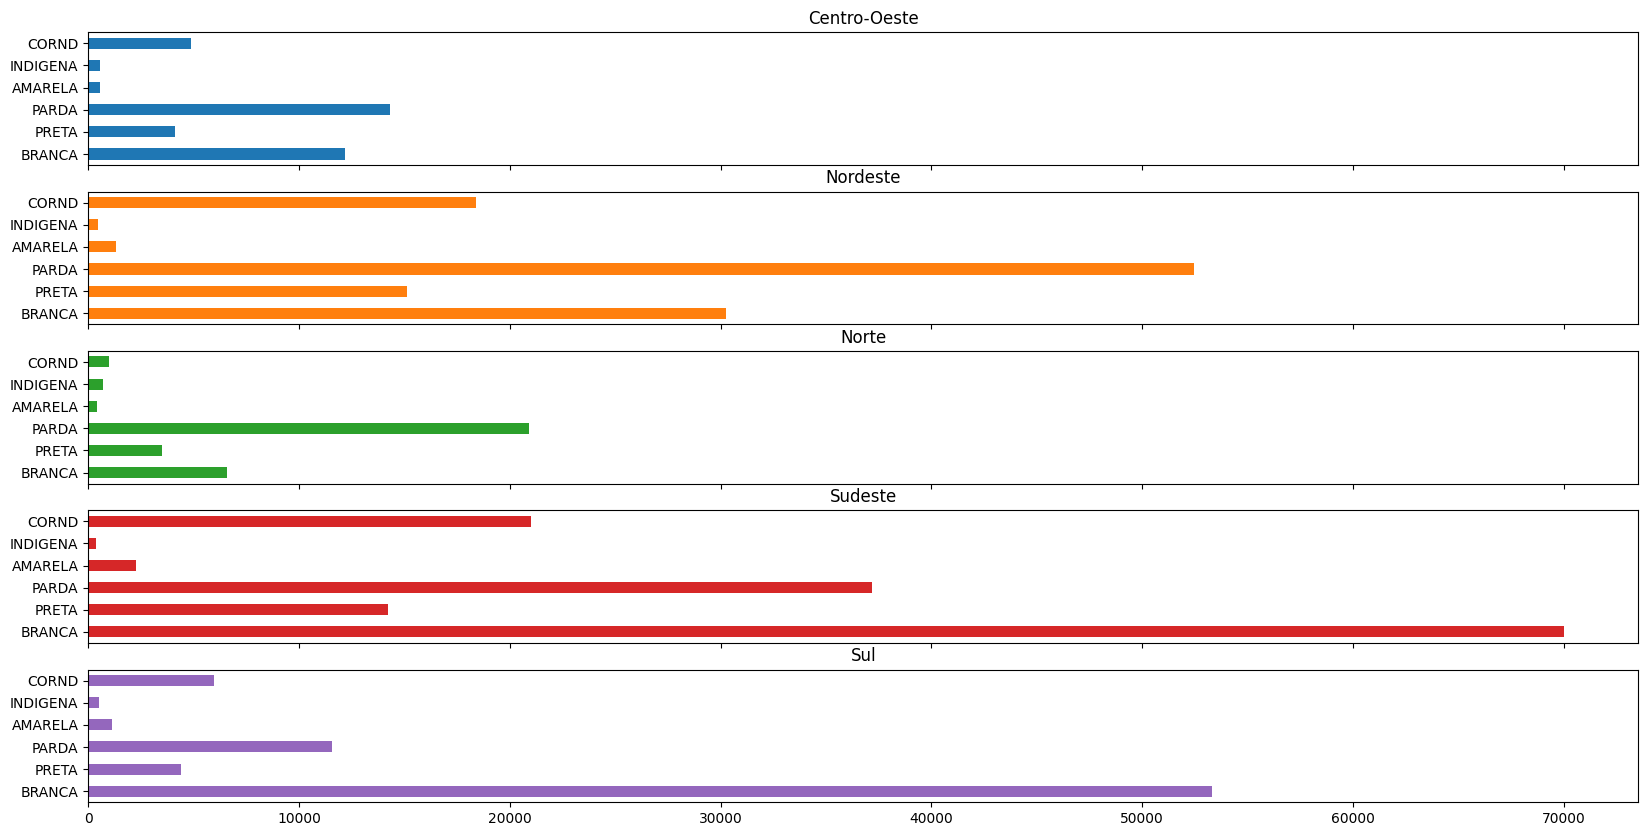

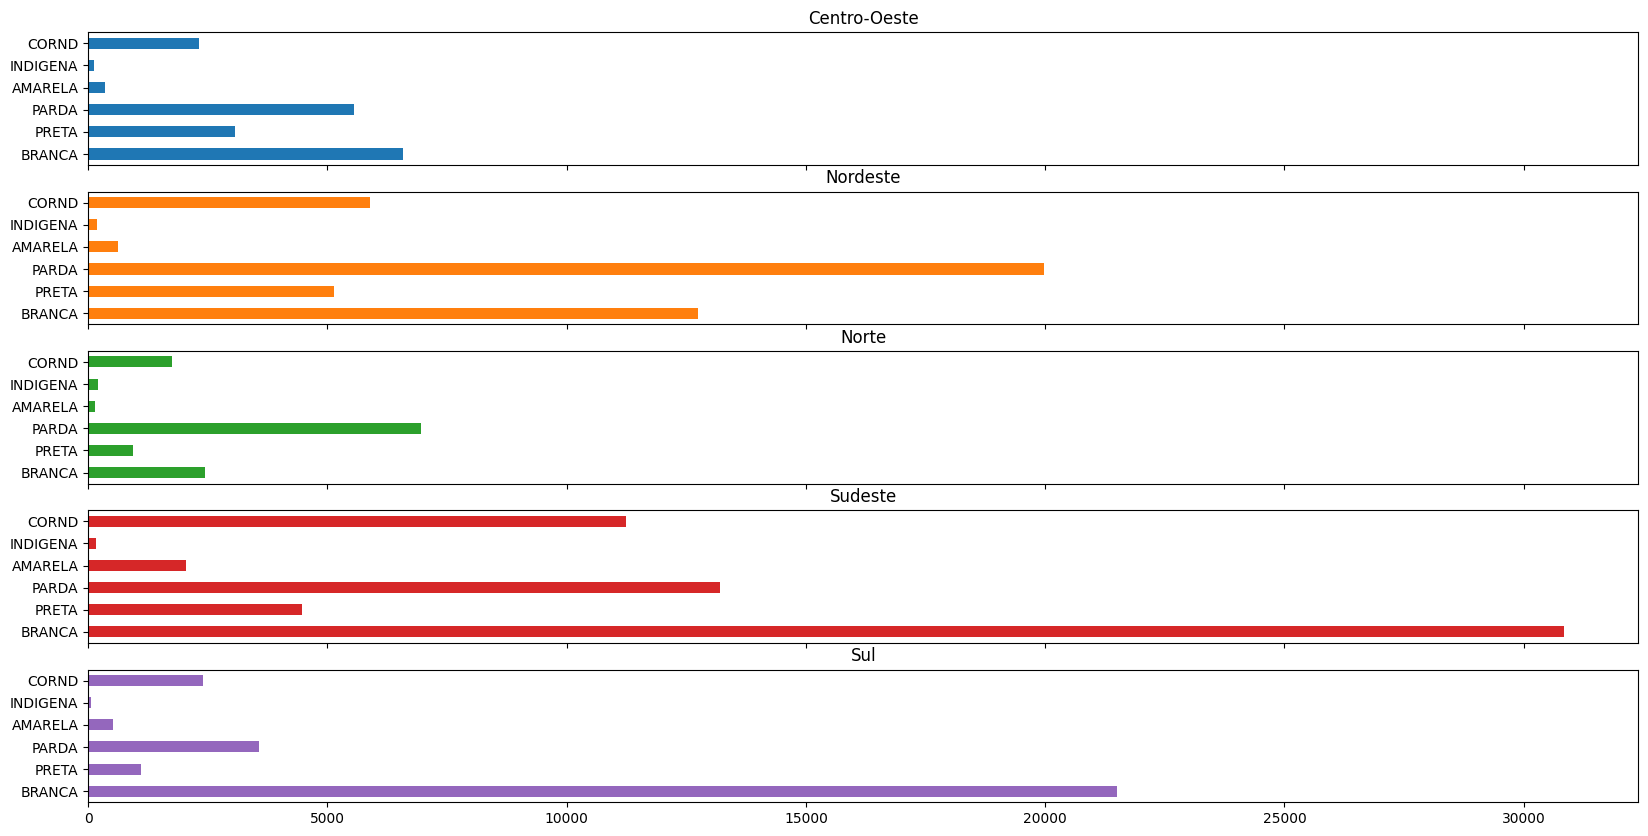

In [6]:
ingressantes.cor.groupby('NO_REGIAO').sum().T.plot(kind='barh', subplots=True, legend=False, figsize=(20,10))
concluintes.cor.groupby('NO_REGIAO').sum().T.plot(kind='barh', subplots=True, legend=False, figsize=(20,10))

array([<AxesSubplot: ylabel='Centro-Oeste'>,
       <AxesSubplot: ylabel='Nordeste'>, <AxesSubplot: ylabel='Norte'>,
       <AxesSubplot: ylabel='Sudeste'>, <AxesSubplot: ylabel='Sul'>],
      dtype=object)

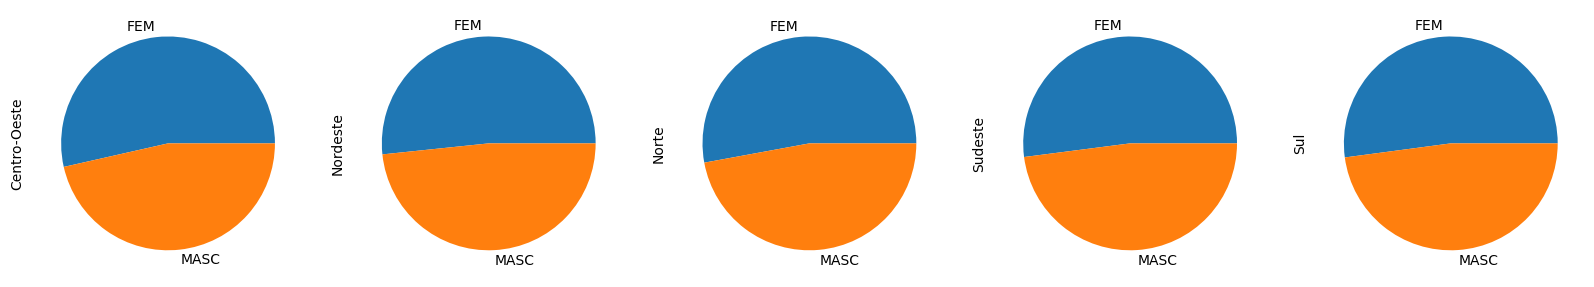

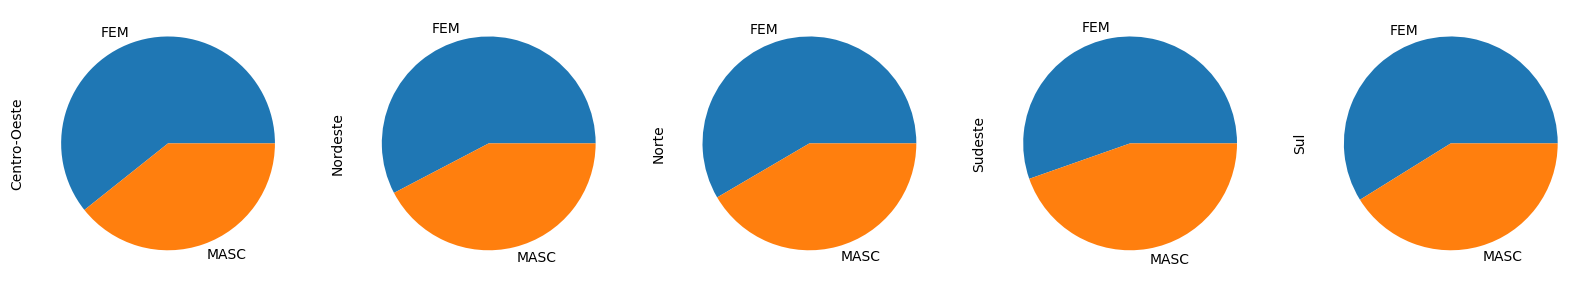

In [7]:
ingressantes.sexo.groupby('NO_REGIAO').sum().T.plot(kind='pie', subplots=True, legend=False, figsize=(20,10))
concluintes.sexo.groupby('NO_REGIAO').sum().T.plot(kind='pie', subplots=True, legend=False, figsize=(20,10))

array([<AxesSubplot: title={'center': 'Centro-Oeste'}>,
       <AxesSubplot: title={'center': 'Nordeste'}>,
       <AxesSubplot: title={'center': 'Norte'}>,
       <AxesSubplot: title={'center': 'Sudeste'}>,
       <AxesSubplot: title={'center': 'Sul'}>], dtype=object)

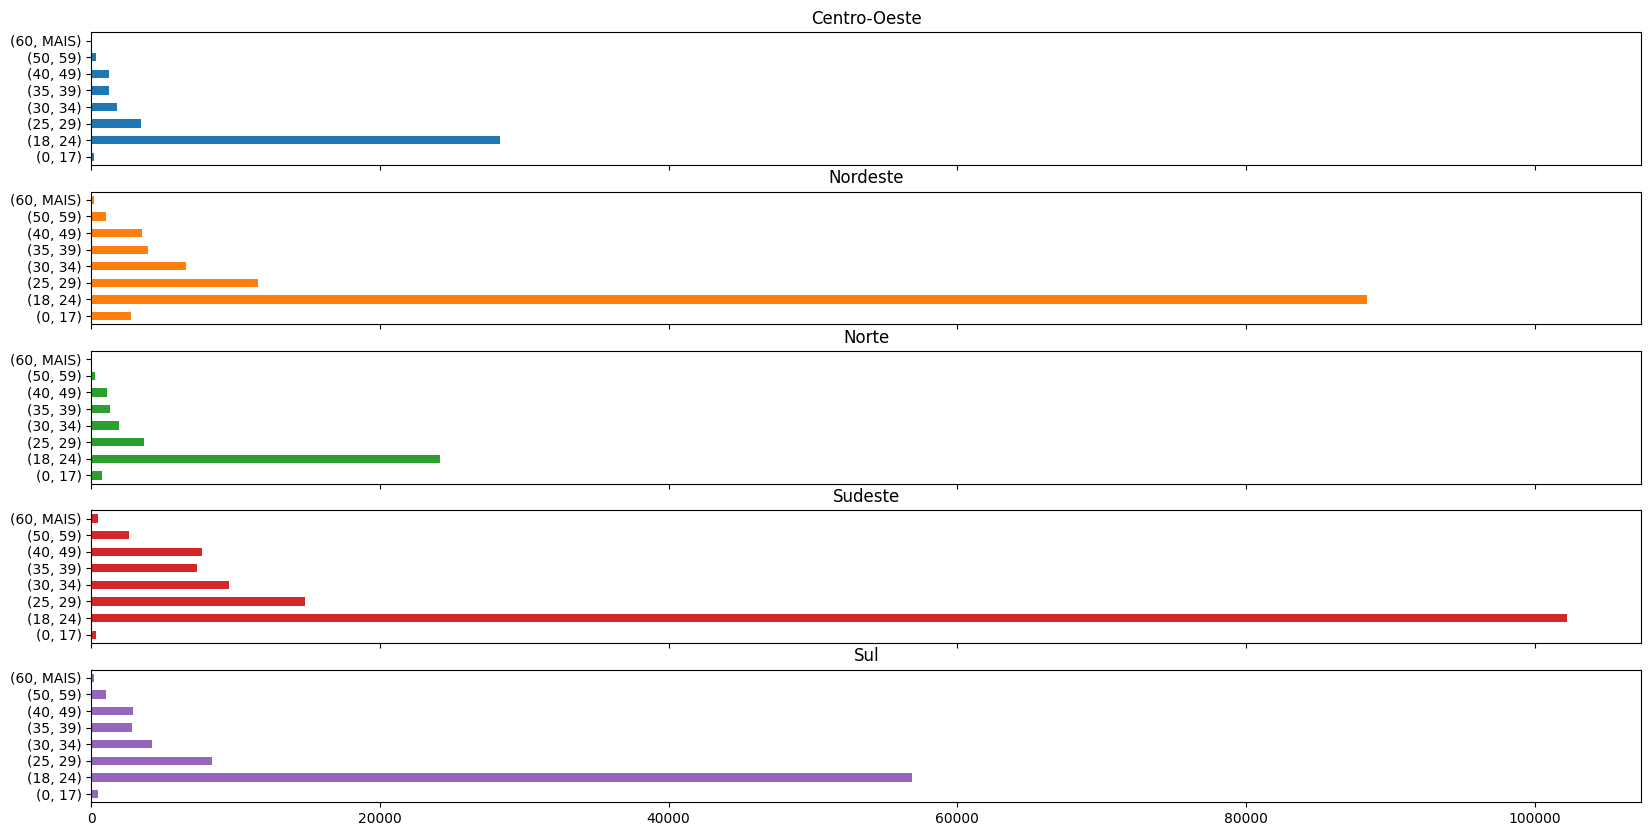

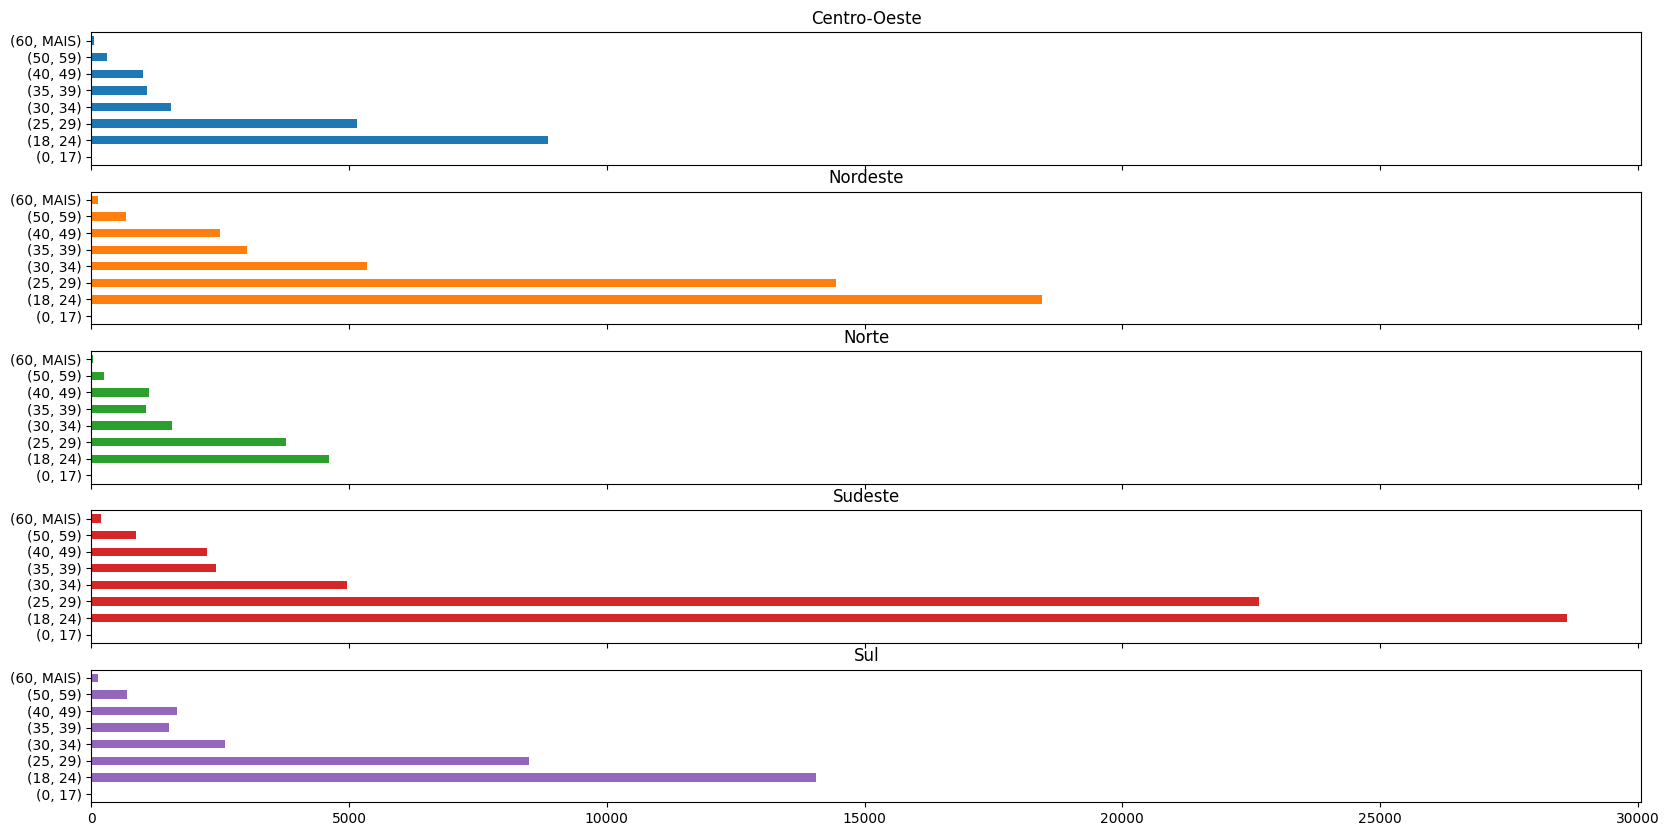

In [8]:
ingressantes.faixa_etaria.groupby('NO_REGIAO').sum().T.plot(kind='barh', subplots=True, legend=False, figsize=(20,10))
concluintes.faixa_etaria.groupby('NO_REGIAO').sum().T.plot(kind='barh', subplots=True, legend=False, figsize=(20,10))

In [9]:
ingressantes.faixa_etaria.merge(dados.municipios.rename(columns={'codigo_ibge':'CO_MUNICIPIO'}), on = 'CO_MUNICIPIO', how = 'left')

,CO_MUNICIPIO,"(0, 17)","(18, 24)","(25, 29)","(30, 34)","(35, 39)","(40, 49)","(50, 59)","(60, MAIS)",nome,latitude,longitude,capital,codigo_uf,siafi_id,ddd,fuso_horario
0,5300108,79,6846,593,311,256,271,84,24,Brasília,-15.7795,-47.9297,1,53,9701,61,America/Sao_Paulo
1,5200258,0,4,12,7,11,14,4,0,Águas Lindas de Goiás,-15.7617,-48.2816,0,52,1052,61,America/Sao_Paulo
2,5200308,0,5,10,9,7,10,4,0,Alexânia,-16.0834,-48.5076,0,52,9205,62,America/Sao_Paulo
3,5200605,0,6,6,16,13,11,2,0,Alto Paraíso de Goiás,-14.1305,-47.5100,0,52,9211,62,America/Sao_Paulo
4,5201108,3,448,121,61,43,47,16,2,Anápolis,-16.3281,-48.9530,0,52,9221,62,America/Sao_Paulo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251,4217204,0,0,0,0,0,0,0,0,São Miguel do Oeste,-26.7242,-53.5163,0,42,8339,49,America/Sao_Paulo
1252,4218202,0,0,0,0,0,0,0,0,Timbó,-26.8246,-49.2690,0,42,8357,47,America/Sao_Paulo
1253,4218509,0,0,0,0,0,0,0,0,Treze Tílias,-27.0026,-51.4084,0,42,8363,49,America/Sao_Paulo
1254,4218707,0,0,0,0,0,0,0,0,Tubarão,-28.4713,-49.0144,0,42,8367,48,America/Sao_Paulo


In [10]:
ingressantes.Moda(4219309)
#RODA ISSO COM TEMPO PORQUE DEMORA UMA HORA
#ingressantes.faixa_etaria['Moda'] = ingressantes.faixa_etaria.reset_index()['CO_MUNICIPIO'].apply(lambda x: ingressantes.Moda(x))

0